In [1]:
import time
import pandas as pd
import numpy as np

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
epochs = [30, 50, 100, 200]

Using TensorFlow backend.


In [2]:
epoch = 200
# Load data
train = pd.read_csv('trips_train_3.csv', header=None)
test = pd.read_csv('trips_test_2.csv', header=None )
scaler = MinMaxScaler(feature_range=(-1, 1))
window_size = 78  # 78 steps in one day
# normalize features
scaled = scaler.fit_transform(train.values)
train = pd.DataFrame(scaled)

series_s = train.copy()
for i in range(window_size):
    train = pd.concat([train, series_s.shift(-(i+1))], axis=1)

train.dropna(axis=0, inplace=True)
# Hacer lo mismo para los datos de prueba
test = test.iloc[:24624, :]  # The rest are all 0s
scaled = scaler.fit_transform(test.values)
test = pd.DataFrame(scaled)

series_s = test.copy()
for i in range(window_size):
    test = pd.concat([test, series_s.shift(-(i+1))], axis = 1)

test.dropna(axis=0, inplace=True)
train = shuffle(train)
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape=(window_size,1), output_dim=window_size, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()
# Train
start = time.time()
model.fit(train_X, train_y, batch_size=100, epochs=epoch, validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

def moving_test_window_preds(n_future_preds):
    ''' n_future_preds - Represents the number of future predictions we want to make
                        This coincides with the number of windows that we will move forward
                        on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array

    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end

    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1, 1))

    return preds_moving

preds_moving = moving_test_window_preds(500)
actuals = scaler.inverse_transform(test_y.reshape(-1, 1))
mse = mean_squared_error(actuals[74:150], preds_moving[74:150])
mae = mean_absolute_error(actuals[74:150], preds_moving[74:150])

# Save data
with open('f_%s_%s_%s.txt' % (epoch, mse, mae), 'w') as f:
    for i in preds_moving:
        f.write("%s\n" % i)

c:\users\kuno\miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
c:\users\kuno\miniconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(78, 1), units=78)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 78, 78)            24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 78)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               343040    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 368,257
Trainable params: 368,257
Non-trainable params: 0
_________________________________________________________________
Trai

35634/35634 [==============================] - 341s 10ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 66/200
35634/35634 [==============================] - 343s 10ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 67/200
35634/35634 [==============================] - 345s 10ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 68/200
35634/35634 [==============================] - 345s 10ms/step - loss: 0.0070 - val_loss: 0.0045
Epoch 69/200
35634/35634 [==============================] - 345s 10ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 70/200
35634/35634 [==============================] - 348s 10ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 71/200
35634/35634 [==============================] - 343s 10ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 72/200
35634/35634 [==============================] - 341s 10ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 73/200
35634/35634 [==============================] - 339s 10ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 74/200
35634/35634 [======

35634/35634 [==============================] - 376s 11ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 141/200
35634/35634 [==============================] - 377s 11ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 142/200
35634/35634 [==============================] - 377s 11ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 143/200
35634/35634 [==============================] - 377s 11ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 144/200
35634/35634 [==============================] - 377s 11ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 145/200
35634/35634 [==============================] - 379s 11ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 146/200
35634/35634 [==============================] - 376s 11ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 147/200
35634/35634 [==============================] - 376s 11ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 148/200
35634/35634 [==============================] - 376s 11ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 149/200
35634/3563

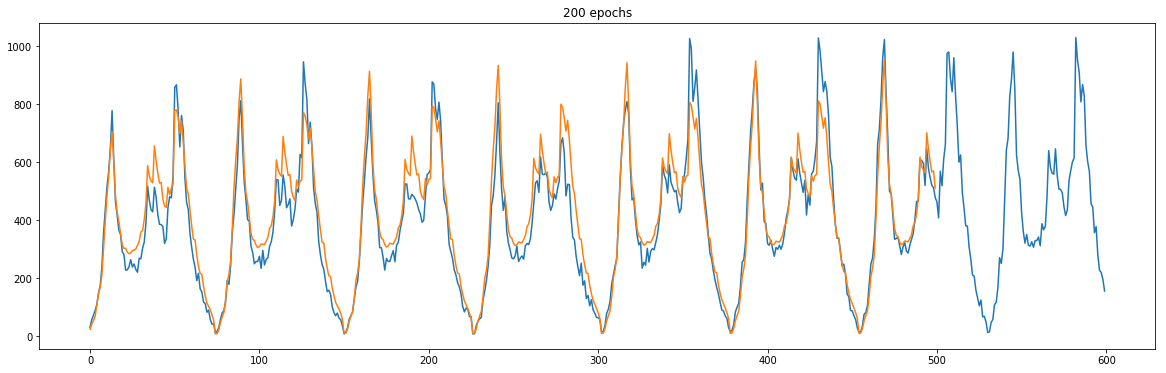

In [4]:
from matplotlib import pyplot

pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[:600])
pyplot.plot(preds_moving[:600])
pyplot.title("200 epochs")
pyplot.show()

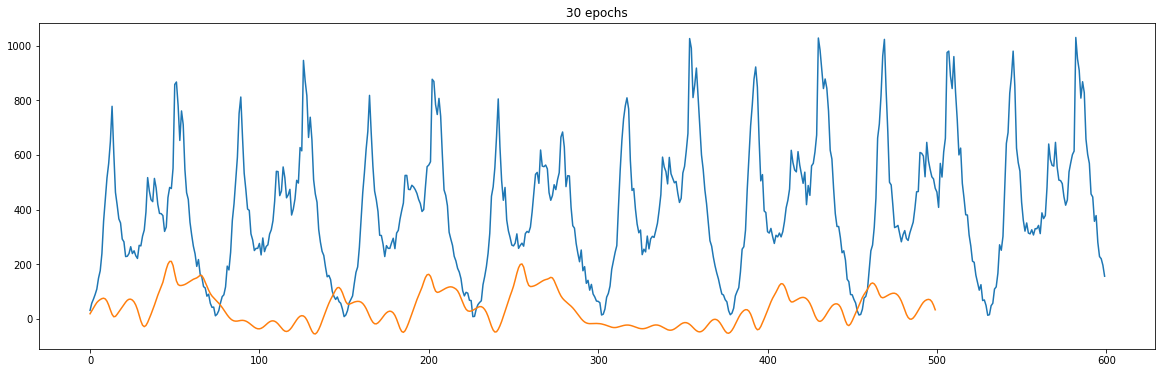

In [8]:
with open("f_30_191360.34899787782_369.8666947640871.txt") as f:
    pyplot.figure(figsize=(20,6))
    pyplot.plot(actuals[:600])
    pyplot.plot(np.array([l[1:-2] for l in f.readlines()]))
    pyplot.title("30 epochs")
    pyplot.show()

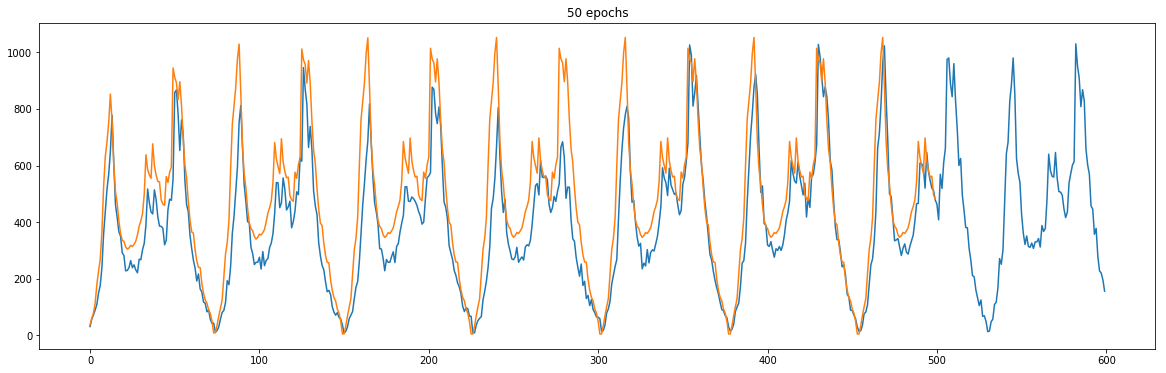

In [9]:
with open("f_50_23261.834132086205_116.21821095441517.txt") as f:
    pyplot.figure(figsize=(20,6))
    pyplot.plot(actuals[:600])
    pyplot.plot(np.array([l[1:-2] for l in f.readlines()]))
    pyplot.title("50 epochs")
    pyplot.show()

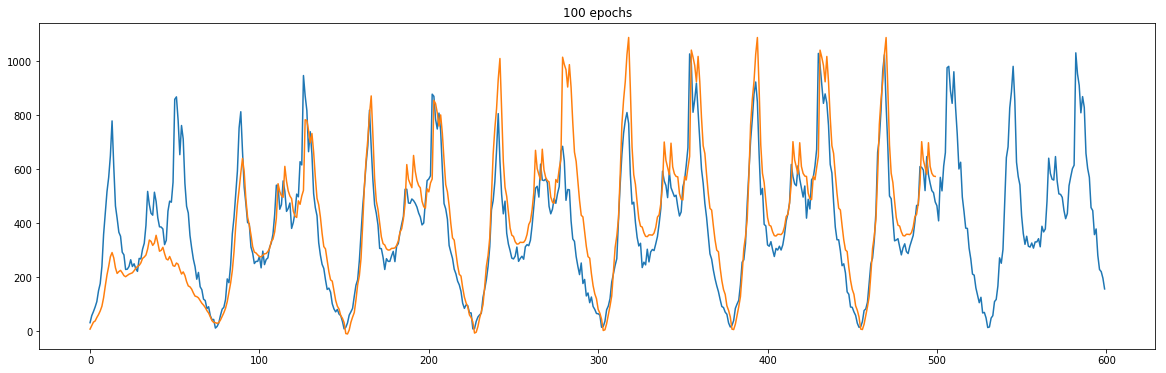

In [11]:
with open("f_100_8694.5463661338_66.40398304085983.txt") as f:
    pyplot.figure(figsize=(20,6))
    pyplot.plot(actuals[:600])
    pyplot.plot(np.array([l[1:-2] for l in f.readlines()]))
    pyplot.title("100 epochs")
    pyplot.show()

In [20]:
model.predict(np.array([scaler.fit_transform(actuals[:78])]))

array([[-0.84483016]], dtype=float32)

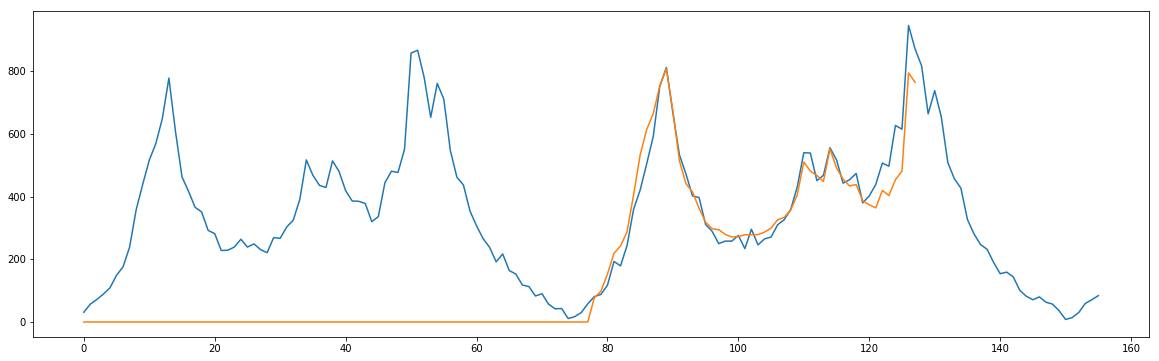

In [91]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[:156])
pyplot.plot(np.concatenate(([[0] for i in range(78)], scaler.inverse_transform(res))))
pyplot.show()

In [71]:
def predict_next(info, n):
    res = []
    for i in range(n):
        base = np.concatenate((scaler.fit_transform(info[i:78]), res)) if res else scaler.fit_transform(info[:78])
        pred = model.predict(np.array([base]))
        res.append(pred[0])
    return res

In [85]:
data_temblor = np.array([[int(l.strip())] for l in open("trips_19_sept.csv").readlines() if l.strip()])

c:\users\kuno\miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


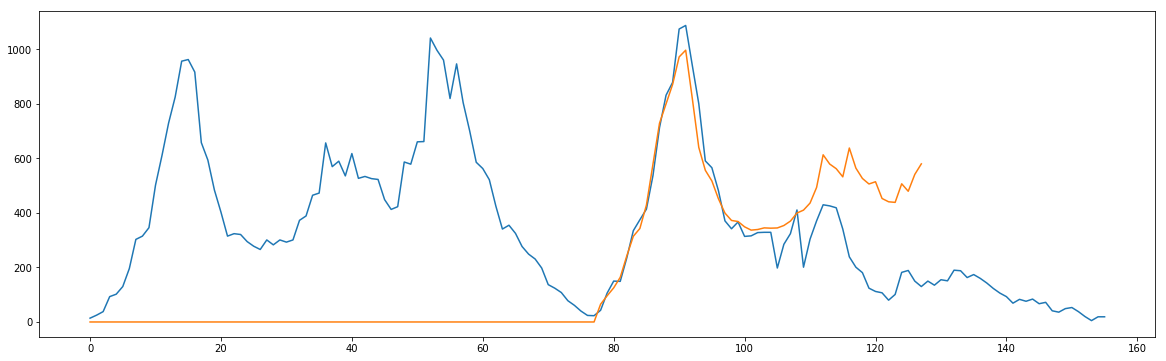

In [102]:
pyplot.figure(figsize=(20,6))
pyplot.plot(data_temblor[:156])
pyplot.plot(np.concatenate(([[0] for i in range(78)], scaler.inverse_transform(predict_next(data_temblor, 50)))))
pyplot.show()

c:\users\kuno\miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


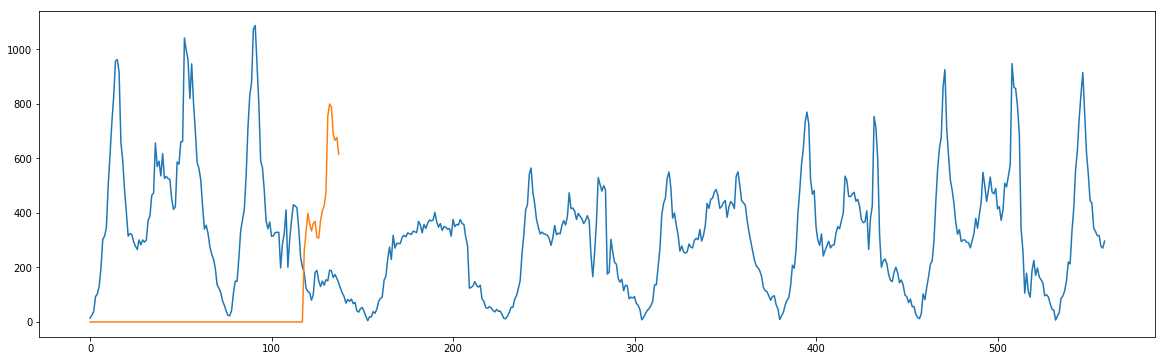

In [117]:
n = 40
pyplot.figure(figsize=(20,6))
pyplot.plot(data_temblor[:560])
pyplot.plot(np.concatenate(([[0] for i in range(78 + n)], scaler.inverse_transform(predict_next(data_temblor[n:], 20)))))
pyplot.show()

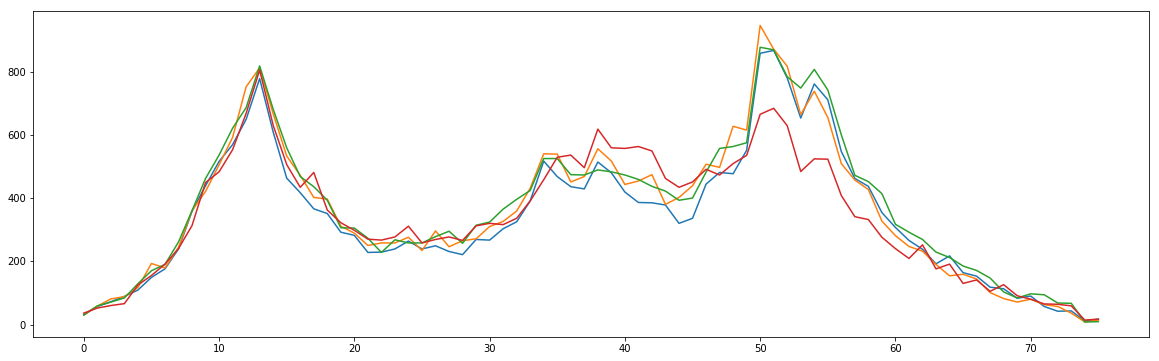

In [130]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[0:76])
pyplot.plot(actuals[76:152])
pyplot.plot(actuals[152:228])
pyplot.plot(actuals[228:304])
# for d in range(5):
#     pyplot.plot(actuals[78*d:78*(d+1)])
pyplot.show()